In [1]:
import numpy as np
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft, ifft, rfft, fft2, ifft2
import rasterio
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def filt5(lon, lat, ingrid, nodata=np.nan):
    """
    Find peaks in 5 directions. Flag as 5
    Finds maximum of a 5x5 sliding window. If the central pixel is the maximum, this is flagged as a one.
    All other pixels are flagged as zero.
    """
    
    nodatidx = ingrid.flatten()*np.nan ## creates single dim array with as much values as the matrix ingrid, with NANs
    outgrid = np.zeros(ingrid.shape)   ## outgrid is a matrix with the shape of ingrid, full of Zeros
    
    #l1 = len(lon)
    #l2 = len(lat)
    l1 = len(lat)
    l2 = len(lon)

    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            subg = ingrid[(i-3):(i+2), (j-3):(j+2)] # return the last 5 rows of the last 5 columns of the matrix
            if np.isnan(subg).sum()==25:    #if all values in submatrix subg are null values:
                outgrid[i,j] = 0
            else:
                vec = np.array(subg).T.flatten()    # array with values of the transpose subg matrix
                ma = np.argmax(subg.flatten())      # index with the maximum value of subg array
               
                mi = np.argmin(subg.flatten())      # index with the minimum value of subg array
                
                
                if ma==12 or mi==12:     #se ma or mi se tratar do valor meio da matrix 5x5 (if the central pixel is the maximum)
                    outgrid[i-1,j-1] = 1      #flagged as 1
                else:
                    outgrid[i-1,j-1] = 0      #all other pixels are flagged as 0
    
    return outgrid

In [3]:
def filt3(lon, lat, ingrid, grid5):
    """
    Find peaks in 3 directions. FLag as 3
    Returns a median smoothed grid of satellite data
    """
    
    outgrid = ingrid*0   # matrix of 0s with shape of ingrid matrix
    #l1=len(lon)
    #l2=len(lat)
    l1 = len(lat)
    l2 = len(lon)
    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            if (grid5[i,j]==0):
                subg = ingrid[(i-2):(i+1), (j-2):(j+1)]       # submatrix subg (3x3) 
                if np.isnan(subg).sum()==9:                   # if all values in submatrix subg (3x3) are null values:
                    outgrid[i-1,j-1] = ingrid[i-1,j-1]
                else:
                    vec = np.array(subg).T.flatten()          # array with values of the transpose subg matrix
                    ma = np.argmax(subg.flatten())            # index with the maximum value of subg array
                    mi = np.argmin(subg.flatten())            # index with the minimum value of subg array
                    
                    if (ma==4 or mi==4):                      #se ma or mi se tratar do valor meio da matrix 3x3
                        outgrid[i-1,j-1] = nanmedian(subg)    # median while ignoring NaNs.
                    else:
                        outgrid[i-1,j-1] = ingrid[i-1,j-1]
            
            else:
                outgrid[i-1,j-1] = ingrid[i-1,j-1]
                
    return outgrid

In [4]:
def boa(lon, lat, ingrid, nodata = np.nan, direction = False):
    
    def filter2(x, filt):
        """
        Workhorse filter from EBImage. Modified so we don't need colorspace and other annoying requirements ????
        """
        
        dx = x.shape                          
        df = filt.shape  
        
        if (df[0]//2 == 0) or (df[1]//2 == 0):
            sys.exit('dimensions of "filter" matrix must be odd')
        if (dx[0] < df[0]) or (dx[1] < df[1]):
            sys.exit("dimensions of 'x' must be bigger than 'filter'")
            
        cx = tuple(elem//2 for elem in dx)    
        cf = tuple(elem//2 for elem in df)    

        wf = np.zeros(shape=dx)       #matrix with zeros with shape of x

        wf[cx[0]-cf[0]-1:cx[0]+cf[0], cx[1]-cf[1]-1:cx[1]+cf[1]] = filt    #colocar valores de filt nos meio da matriz wf

        wf = fft2(wf)         #apply the 2 dimensional discrete fourier transform                  
    
        dim_x = np.array(dx[0:2])
        dim_x =np.append(dim_x, math.prod(dx)/math.prod(dx[0:2]))     

        aux1 = np.arange(cx[0],dx[0]+1)
        aux2 = np.arange(1,cx[0])
        index1 = np.concatenate((aux1, aux2), axis=None)  
        index1 = index1-1   

        aux3 = np.arange(cx[1], dx[1]+1)
        aux4 = np.arange(1,cx[1])
        index2 = np.concatenate((aux3, aux4), axis=None) 
        index2 = index2-1   
        
        #estes index vao ser usados para reordenar valores da matriz y
        
        y = (scipy.fft.ifft2(scipy.fft.fft2(x)*wf)).real

        y = np.array([[y[i][j] for j in index2] for i in index1])
        
        return y
    
#======================================================#
# Main BOA algorithm                                   
#======================================================#      
    gx = np.matrix([[-1,0,1],[-2,0,2],[-1,0,1]])        #filter in x
    gy = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])        #filter in y
        
    np.nan_to_num(ingrid, nan=-9999, posinf=-9999, neginf=-9999) ##replace NaN and inf values with -9999
        
    grid5 = filt5(lon, lat, ingrid, nodata = nodata)
    grid35 = filt3(lon, lat, ingrid, grid5)

    # make an index of bad values and land pixels.
    grid35 = grid35.astype("float")
    grid35[grid35 == -9999]=np.nan
    naidx = np.isnan(grid35)        #matriz com dimensões de grid35 (True se valor for nan, False caso contrario)
    # convert these (True values of naidx) to zeros (in grid35) for smoothing purposes
    grid35[naidx]=0  

    # perform the smoothing (Sobel filter)  
    tgx = filter2(grid35, gx)
    tgy = filter2(grid35, gy)
        
    tx = tgx/np.nansum(abs(np.array(gx).flatten()))    #tgx a dividir pela soma dos valores absolutos do filtro gx
    ty = tgy/np.nansum(abs(np.array(gy).flatten()))    #tgy a dividir pela soma dos valores absolutos do filtro gy
    front = np.sqrt((tx**2)+(ty**2))                   #front é raiz quadrada da soma dos quadrados dos valores de tx e ty


#======================================================#
# landmask and edge dilation
#======================================================#

    land = naidx*1
    land = land.astype("float")

    land[land==1] = np.nan
    land[~np.isnan(land)] = 1

    
#======================================================#
# landmask and edge dilation using raster!
#======================================================#

    l2=lon.size    #using size because lon and lat are matrices
    l1=lat.size

    midx = land*np.nan

    midx[5:(l1-2), 5:(l2-2)] = 1

    land = np.multiply(land, midx)
    
    
    ssr = np.flip(front.T, 0)
    

    #Apply a sliding window kernell to the land matrix
    mask = scipy.signal.convolve2d(np.flip(land.T, 0), np.array([0,0,0,0,1,0,0,0,0]).reshape(3,3), boundary='symm', mode='same')

    matrix_front =  mask * np.flip(front.T, 0)   #matrix of mask raster file * matrix of ssr raster file


    
    if direction==True:
#   ************************************
#   *** Calculate Gradient Direction ***
#   ************************************
        
        n = ingrid.size       #nr os elements of the grid matrix
        grid_shape = ingrid.shape

        GRAD_DIR = np.zeros(n)     #matrix of zeros with shape of ingrid matrix

        for i in range(n):
            GRAD_DIR[i] = math.atan2(tgy.flatten()[i], tgx.flatten()[i])
    
        GRAD_DIR = GRAD_DIR*180/math.pi    # change radians to degrees

        OK = np.where(GRAD_DIR < 0)

        OK = np.array(OK)

        if OK.size >1:
            GRAD_DIR[OK] = 360 - abs(GRAD_DIR[OK])    #Adjust to 0-360 scheme (make negative degrees positive)
    
        GRAD_DIR = (360 - GRAD_DIR + 90) % 360     #Convert degrees so that 0 degrees is North and East is 90 degrees
        GRAD_DIR = GRAD_DIR.reshape(grid_shape)
        
        
        grad_dir = np.flip(GRAD_DIR.T, 0)


        # create array grdir (result from multiplication of grad_dir_matrix and mask_matrix (its the conv matrix))
        grdir_matrix = np.flip(GRAD_DIR.T, 0)*mask


        #No R eles pôem numa named_list por isso aqui pus num dicionário (algo equivalente)
        dic = {'grdir': grdir_matrix, 'front': matrix_front}
        
    else:
        matrix_front

        
    return matrix_front

### Interpretação dos valores obtidos através do BOA algorithm



In [5]:
from scipy.ndimage import rotate

In [408]:
test = np.ones((100,100))     
test[:, 20:21] = 9
#test[:, 15:16] = 9
#test[50:51, :10] = 9
#test[60:61, :] = 9
#Dummy matrix de 1s mas com uma linha vertical de 9s

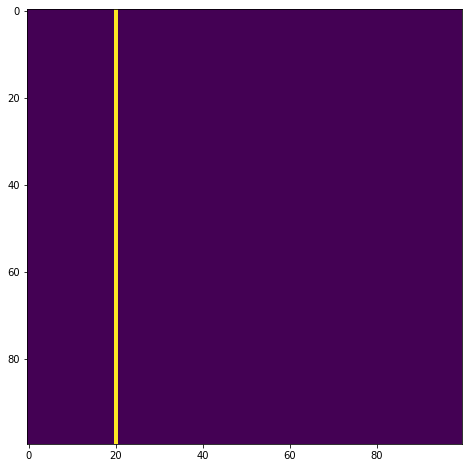

In [409]:
plt.imshow(test)

In [410]:
# matrizes de longitude e latitude necessárias para a aplicação da função BOA
lon2 = np.arange(100)
lat2 = np.arange(100)

In [411]:
front_dummy = boa(lon=lon2, lat=lat2, ingrid=test, nodata = np.nan, direction = False)

In [317]:
#np.unique(front_dummy)

In [412]:
front_dummy = np.flip(front_dummy, axis=0)
front_dummy = np.array([[front_dummy[j][i] for j in range(len(front_dummy))] for i in range(len(front_dummy[0])-1,-1,-1)])


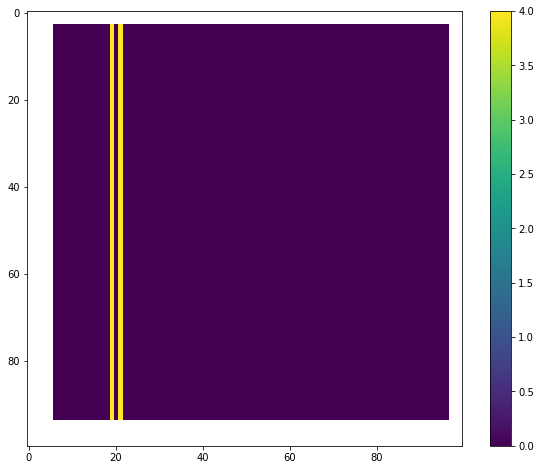

In [413]:
plt.imshow(front_dummy)
plt.colorbar()

#### Conclusão:

Como se pode ver, a aplicação do BOA na dummy matrix retorna-nos duas "frentes" cujo valor é 4. Ora como a diferença entre os valores dos pixeis era 8 (9-1) então os valores retornados no BOA são metade da "diferença de temperaturas originais"

In [422]:
test2 = np.ones((30,30))
#test2[5,5] = 10
np.fill_diagonal(test2, 5)
test2[[0,1,2,3,4,5,6],[0,1,2,3,4,5,6]] = 1

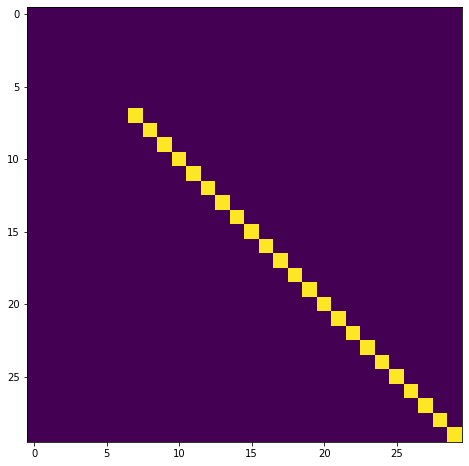

In [423]:
plt.imshow(test2)

In [424]:
# matrizes de longitude e latitude necessárias para a aplicação da função BOA
lon3 = np.arange(30)
lat3 = np.arange(30)

In [425]:
front_dummy2 = boa(lon=lon3, lat=lat3, ingrid=test2, nodata = np.nan, direction = True)

In [426]:
front_dummy2 = np.flip(front_dummy2, axis=0)
front_dummy2 = np.array([[front_dummy2[j][i] for j in range(len(front_dummy2))] for i in range(len(front_dummy2[0])-1,-1,-1)])


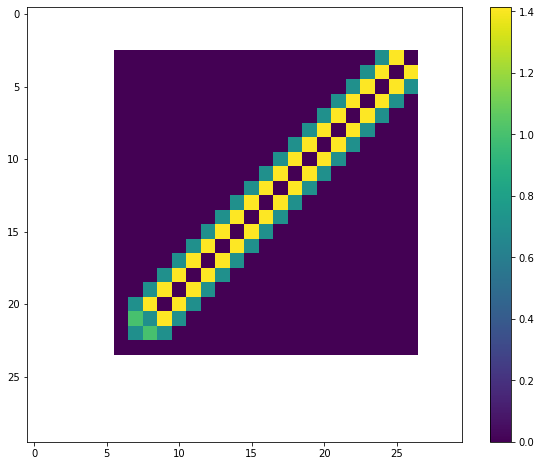

In [427]:
plt.imshow(front_dummy2)
plt.colorbar()

In [428]:
front_dummy2

array([[           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,

### Brincar com Matrizes

In [320]:
plt.rcParams["figure.figsize"] = 10, 8

In [568]:
test = np.ones((100,100))

#estas variaveis definem os limites horizontais e verticais do quadrado interios
h1 = int(test.shape[0]/2-20)
h2 = int(test.shape[0]/2+20)
v1 = int(test.shape[1]/2-20)
v2 = int(test.shape[1]/2+20)

test[h1:h2, v1:v2] = 5    #criar um quadrado com aqueles limites estabelecidos acima

#test[int(test.shape[0]/2):int(test.shape[0]/2+20), int(test.shape[1]/2-20):int(test.shape[1]/2+20)] = 5

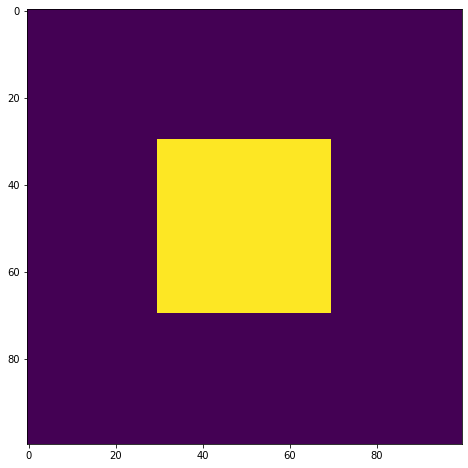

In [569]:
plt.imshow(test);

In [570]:
#estas variaveis servem para definir a diagonal que cruza o quadrado da matriz
d1 = list(range(h1, v2))
d2 = list(range(h1, v2))

In [571]:
test[d1, d2] = 20

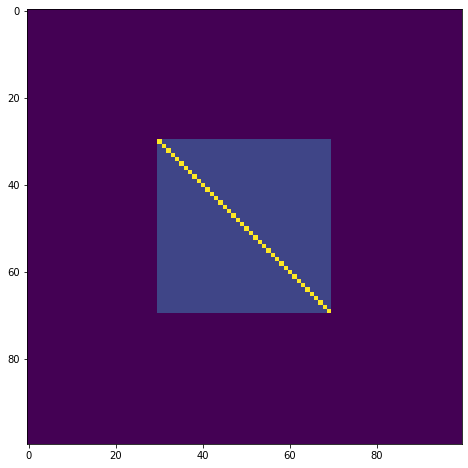

In [572]:
plt.imshow(test);

In [573]:
new_d1 = np.arange(h1,v2-10)
new_d2 = np.arange(h1+10, v2)

In [574]:
test[new_d1, new_d2] = 40

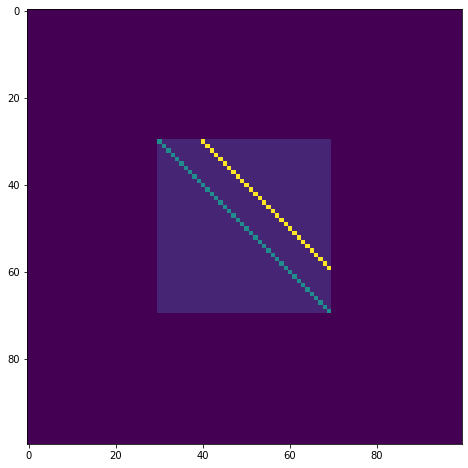

In [575]:
plt.imshow(test)

In [576]:
new2_d1 = np.arange(h1,v2-20)
new2_d2 = np.arange(h1+20, v2)

In [577]:
test[new2_d1, new2_d2] = 60

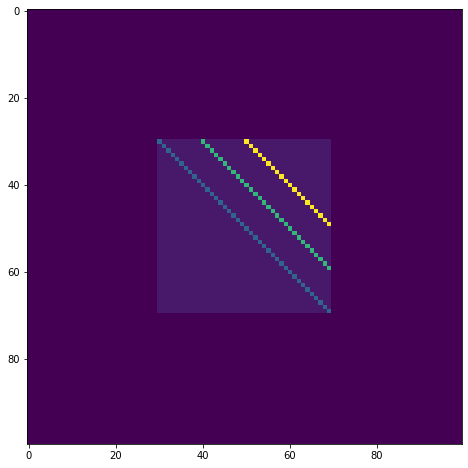

In [578]:
plt.imshow(test)

In [579]:
lon2 = np.arange(100)
lat2 = np.arange(100)


In [580]:
front2 = boa(lon=lon2, lat=lat2, ingrid=test, nodata = np.nan, direction = False)

In [583]:
#front2 = np.flip(front2, axis=0)
front2 = np.array([[front2[j][i] for j in range(len(front2))] for i in range(len(front2[0])-1,-1,-1)])
front2


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

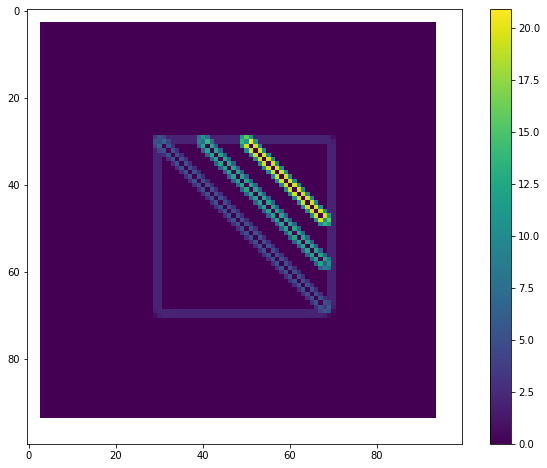

In [584]:
plt.imshow(front2)
plt.colorbar()

In [179]:
np.nanmax(front2)

2.0

In [150]:
y = front2.flatten()

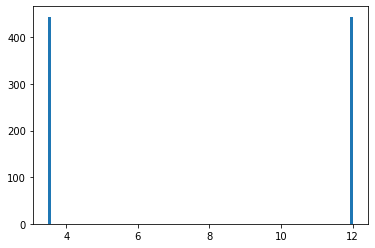

In [132]:
plt.hist(y[y>1], bins=100);

In [151]:
np.nanmin(y[y>1])

3.9999999999999987